In [1]:
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from sklearn import preprocessing
import visdom

/home/hang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Number of samples 55000 Shape of y[(55000, 10)] Shape of X[(55000, 784)]


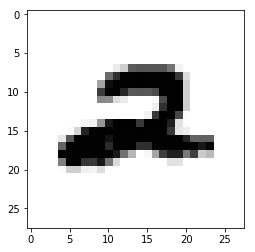

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples
print("Number of samples {} Shape of y[{}] Shape of X[{}]"
      .format(n_samples, mnist.train.labels.shape, mnist.train.images.shape))
plt.imshow(np.reshape(-mnist.train.images[4242], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))

plt.show()

In [6]:
x,y=mnist.train.next_batch(1000)
mask=np.argmax(y,1)==1
X_train=x[mask]
Y_train=y[mask]
print(X_train.shape)
print(Y_train.shape)

(121, 784)
(121, 10)


In [7]:
x,y=mnist.train.next_batch(1000)
mask=np.argmax(y,1)==0
X_train2=x[mask]
Y_train2=y[mask]
print(X_train2.shape)
print(Y_train2.shape)

(106, 784)
(106, 10)


In [8]:
Y_train=np.zeros((134,1))
Y_train2=np.ones((109,1))

In [9]:
Xdata=np.concatenate([X_train,X_train2],0)
Ydata=np.concatenate([Y_train,Y_train2])
print(Ydata.shape)
print(Xdata.shape)

(243, 1)
(227, 784)


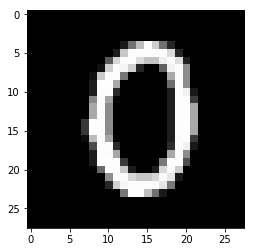

In [10]:
plt.imshow(Xdata[210].reshape(28,28),interpolation='none',cmap=plt.get_cmap('gray'))
plt.show()

In [11]:
# encoder neural network - take as input observation x, output mu and sigma of latent variable z and content h
class Encoder(object):
    def __init__(self,inputs,hidden_dim,z_dim,h_dim):
        self.X=inputs
        self.layer_dims=[6, hidden_dim,hidden_dim, z_dim * 2 + h_dim] # output of Encoder (z_mu, z_sigma, h)
        self.nz=z_dim
        self.nh=h_dim

    
    def encoding(self):
        A=self.X
        keep_prob=1
        x = tf.reshape(A, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same')
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same')
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same')
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        A = tf.layers.dense(x,units=500,activation=tf.nn.relu)
        A1 = tf.layers.dense(A, units=self.nz) *0.01
        A2 = tf.layers.dense(A,units=self.nz)
        A3 = tf.layers.dense(A,units=self.nh)

        return A1, A2, A3

In [12]:
# decoder neural network - take as input latent variable z, output reconstructed x_hat
class Decoder(object):
    def __init__(self,inputs,hidden_dim):
        self.X=inputs
        self.nz = inputs.get_shape().as_list()[1]
        self.nhidden=hidden_dim
    def decoding(self):
        keep_prob=1
        A=self.X
       
        x = tf.layers.dense(A,units=500,activation=tf.nn.relu)
        x = tf.layers.dense(A, units=3136, activation=tf.nn.relu)
        
        x = tf.reshape(x, (-1,7,7,64))
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=1, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)

        return x

In [15]:
# built model
tf.reset_default_graph()
with tf.name_scope('inputs'):
    X = tf.placeholder("float", shape=[None, 28*28]) 
#     Y = tf.placeholder("float", shape=[None, 10]) 
with tf.name_scope('encoding_stage'):
    encoder=Encoder(inputs=X,hidden_dim=500,z_dim=2,h_dim=100)
    z_log_sigma_0,z_mu_0,h=encoder.encoding()
    epsilon = tf.random_normal(tf.shape(z_mu_0),0,1,dtype=tf.float32)
    Z = np.dot(tf.exp(z_log_sigma_0/2) , epsilon) + z_mu_0

with tf.name_scope('iaf_stage'):
    z_sigmas=[]
    for t in range(4):
        reverse = t>0
        if reverse:
            Z = Z[:,::-1]
        IAF = AutoregNN(input_z=Z,input_h=h,layer_dims=[102,400,400,4],idx=t)
        m,s = IAF.iaf()
        z_sigma = tf.sigmoid(s)
        Z = np.dot(z_sigma , Z) + np.dot(1 - z_sigma ,  m)
        z_sigmas.append(z_sigma)

with tf.name_scope('decoding_stage'):
    decoder=Decoder(inputs=Z,hidden_dim=500)
    x_mu_hat = decoder.decoding()
#     x_mu_hat = tf.reshape(x_mu_hat, (-1,784))
#     X_ = tf.reshape(X,(-1,784))
#     print(x_mu_hat.get_shape())

In [16]:
# vae - iaf negative evidence lower bound - based on monte carlo sampling
def neg_elbo(X,x_mu_hat,Z):
    # log p(x|z_t)
    log_px = -tf.reduce_sum(X * tf.log(1e-10 + x_mu_hat) + (1-X) * tf.log(1e-10 + 1 - x_mu_hat), axis=-1)   
    
    # log p(z_t)
    log_pz = -tf.reduce_sum(0.5*Z**2, axis=-1)
  
    #log q(z_t|x)
    det=np.zeros_like(z_sigmas[0])
    for item in z_sigmas:
        det+=tf.log(item)    
    log_qz = -tf.reduce_sum(0.5*epsilon**2 + 0.5*z_log_sigma_0+det,axis=-1) 
    
    return tf.reduce_mean(log_px+log_qz-log_pz) 

In [17]:
# training
def training(X_train,num_epochs = 1000, batch_size = 32, save_every=1000,log_every=10,learning_rate = 0.001, verbose = False):

    with tf.name_scope('training_loss'):
        loss = neg_elbo(X,x_mu_hat,Z)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    # training
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(num_epochs):

            idx=np.random.choice(200,10)
            mini_batch=X_train[idx]
#             mini_batch=mnist.train.next_batch(10)[0]
            _,temp_cost=sess.run([optimizer,loss],{X:mini_batch})

            if verbose and epoch % log_every ==0:
                print('%d-th train ' % (epoch) + 'cost:{} '.format(temp_cost))
                
                
                
            if epoch%save_every==0:
                save_path = saver.save(sess, "iafmnist/iafmnist2.ckpt")

    return None

In [ ]:
training(Xdata,num_epochs=10000, batch_size = 10, log_every = 1000,save_every=2000, verbose=True)

0-th train cost:547.8444213867188 
1000-th train cost:92.60768127441406 
2000-th train cost:77.12105560302734 
3000-th train cost:78.41287231445312 
4000-th train cost:61.76469802856445 
5000-th train cost:72.14424133300781 
6000-th train cost:64.36199951171875 


INFO:tensorflow:Restoring parameters from iafmnist/iafmnist2.ckpt


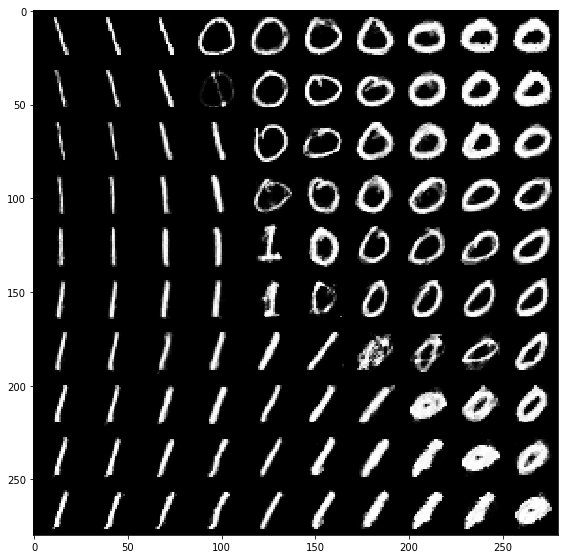

In [245]:
nx = ny = 10
batch_size = 64
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "iafmnist/iafmnist2.ckpt")
    d = np.zeros([batch_size,2],dtype='float32')
    for i, yi in enumerate(x_values):
        for j, xi in enumerate(y_values):
            z_mu = np.array([[xi, yi]])
            d[0] = z_mu
            x_mean = sess.run(x_mu_hat, feed_dict={Z: d})
            canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()
plt.show()

In [14]:
# autoregressive neural network - take as input z_(t-1) and h, output mean and sigma of z_(t)
class AutoregNN(object):
    def __init__(self,input_z,input_h,layer_dims,idx,verbose = False):
        self.Z = input_z
        self.h = input_h
        self.z_dim = input_z.get_shape().as_list()[1]
        self.h_dim = input_h.get_shape().as_list()[1]
        self.D= self.z_dim
        self.layer_dims=layer_dims # z_dim + h_dim, arbitrary, arbitrary, z_dim + z_dim
        assert self.layer_dims[0] == self.z_dim + self.h_dim
        assert self.layer_dims[-1] == self.z_dim * 2
        self.verbose = verbose
        
        with tf.variable_scope('autoregressive_nn'+str(idx)):
            self.parameters=self._initialize_parameters()
        with tf.name_scope('autoregressive_nn'+str(idx)):
            self.mask=self.build_mask() 
        
    #initialize parameters
    def _initialize_parameters(self):
        L = len(self.layer_dims)
        parameters={}
        for l in range(1,L):
            
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.xavier_initializer())
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.zeros_initializer()) 
       
        #for direct connection
        parameters['WA']=tf.get_variable('WA',[self.layer_dims[L-1],self.z_dim],initializer=tf.contrib.layers.xavier_initializer())
        parameters['bA']=tf.get_variable('bA',self.layer_dims[L-1],initializer=tf.zeros_initializer())
        
        return parameters 

    # build mask    
    def single_mask(self, m_h, l, Isoutput=False):
        if l==0:
            raise ValueError('No mask for W0')        
        if Isoutput==False:
            M=np.array([[m_h[l][k]>=m_h[l-1][d] for d in range(self.layer_dims[l-1])] for k in range(self.layer_dims[l])],dtype=int)
        if Isoutput==True:
            M=np.array([[m_h[l][k]>m_h[l-1][d] for d in range(self.layer_dims[l-1])] for k in range(self.layer_dims[l])],dtype=int)
        if self.verbose:
            print('M%d:'%l + '{}'.format(M))
        return M    
    
    def build_mask(self):
        L=len(self.layer_dims)
        mask={}        
        #create mask number of each unit
        input_sel_z = np.arange(0,self.z_dim)
        input_sel_h = np.zeros(self.h_dim)-1 # a little trick to let input h be fully connected to first hidden layer 
                                    # it shouldn't have mask, but we set the mask to be True = set input_sel_h smaller than any mask number
        input_sel = np.concatenate((input_sel_z,input_sel_h))
        output_sel = np.concatenate((input_sel_z, input_sel_z))
        m_h=[input_sel]
        #np.random.seed(0)
        for l in range(1,L-1):
            m_h.append(np.random.randint(self.D-1,size=self.layer_dims[l]))
        m_h.append(output_sel)
        if self.verbose:
            print('m_h: {}'.format(m_h))
        
        for l in range(1,L-1):
            M=self.single_mask(m_h,l,Isoutput=False)
            mask['M'+str(l)]=tf.constant(M,dtype=tf.float32,name='M'+str(l))
        for l in range(L-1,L):           
            M=self.single_mask(m_h,l,Isoutput=True)
            mask['M'+str(l)]=tf.constant(M,dtype=tf.float32,name='M'+str(l))
    
        # for direct connection
        input_sel_direct = input_sel_z
        output_sel_direct = np.concatenate((input_sel_z, input_sel_z))
        M=np.array([[i<j for i in input_sel_direct] for j in output_sel_direct],dtype=int)
        if self.verbose:
            print('MA: {}'.format(M))
        mask['MA']=tf.constant(M,dtype=tf.float32,name='MA')                      
        
        return mask
    
    # forward compute
    def iaf(self):
        L=len(self.layer_dims)    
        A_in=tf.concat((self.Z,self.h),axis = 1)
        A = A_in
        for l in range(1,L):
            masked_W=np.dot(self.parameters['W'+str(l)], self.mask['M'+str(l)])
            b=self.parameters['b'+str(l)]
            Z=tf.add(tf.matmul(A,tf.transpose(masked_W)),b)
            if l < (L-1):  # activation for hidden layer
                A=tf.nn.relu(Z)
            else:  # activation for output layer
                A=Z 
                
        #for direct conection
        masked_W= np.dot(self.parameters['WA'], self.mask['MA'])
        A_direct=tf.matmul(self.Z,tf.transpose(masked_W))
        
        A = tf.add(A,A_direct)
        A1 = A[:,self.z_dim:] #s
        A2 = A[:,:self.z_dim] #m

        
        return A1,A2